In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, AutoConfig, T5ForConditionalGeneration
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix

import math
import os
import json
import datasets
from matplotlib import pyplot as plt
from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

In [2]:
def model(x, m, w):
    loss = (x * 2).mean() + (m * 3).mean() + w.mean()
    new_mem = 3 * x[:len(m)] + m
    return loss, new_mem

In [57]:
x1, mem = torch.ones(10, requires_grad=True), torch.ones(2, requires_grad=True)
x2 = torch.ones(10, requires_grad=True)
w = torch.Tensor([2]* 10)
w.requires_grad = True

In [58]:
memc = mem.clone()
loss1, new_mem1 = model(x1, memc, w)
new_mem1.retain_grad()
loss1.backward()
x1.grad, mem.grad, w.grad

(tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000]),
 tensor([1.5000, 1.5000]),
 tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]))

In [60]:
memc.grad

/tmp/ipykernel_5345/1414870003.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  memc.grad


In [51]:
# loss2, new_mem2 = model(x2, new_mem1, w)
# loss2.backward(retain_graph=True)
# x1.grad, mem.grad, x2.grad, w.grad

In [52]:
loss2, new_mem2 = model(x2, new_mem1, w)
loss2.backward()
x1.grad, mem.grad, x2.grad, w.grad


(tensor([4.7000, 4.7000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000]),
 tensor([3., 3.]),
 tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000]),
 tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000]))

In [53]:
loss2, new_mem2 = model(x2, new_mem1, w)
loss2.backward()
x1.grad, mem.grad, x2.grad, w.grad

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [467]:
x1, mem = torch.ones(10, requires_grad=True), torch.ones(2, requires_grad=True)
x2 = torch.ones(10, requires_grad=True)

loss1, new_mem1 = model(x1, mem, w)
loss2, new_mem2 = model(x2, new_mem1, w)

new_mem1.register_hook(lambda x: print(f'new_mem1 grad: {x}'))
new_mem2.register_hook(lambda x: print(f'new_mem2 grad: {x}'))
loss2.backward()
# x1.grad, mem.grad, x2.grad


new_mem1 grad: tensor([1.5000, 1.5000])


In [462]:
x1, mem = torch.ones(10, requires_grad=True), torch.ones(2, requires_grad=True)
x2 = torch.ones(10, requires_grad=True)

# loss1, new_mem1 = model(x1, mem, w)
loss2, new_mem2 = model(x2, mem, w)
loss2.backward()
loss2, new_mem2 = model(x2, mem, w)
loss2.backward()

x1.grad, mem.grad, x2.grad

(None,
 tensor([3., 3.]),
 tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000,
         0.4000]))

In [463]:
x1, mem = torch.ones(10, requires_grad=True), torch.ones(2, requires_grad=True)
x2 = torch.ones(10, requires_grad=True)

loss1, new_mem1 = model(x1, mem, w)
loss2, new_mem2 = model(x2, new_mem1, w)
loss1.backward()
print(x1.grad, mem.grad, x2.grad)
loss2.backward()
print(x1.grad, mem.grad, x2.grad)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000]) tensor([1.5000, 1.5000]) None
tensor([4.7000, 4.7000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000]) tensor([3., 3.]) tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000])


In [275]:
loss2

tensor(13., grad_fn=<AddBackward0>)

In [389]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import sys
sys.path.append('..')
from modeling_rmt import RMTEncoderForSequenceClassification
from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

## RMT

In [390]:
model_name = 't5-base'

# experiment_path = "/home/bulatov/bulatov/runs/finetune/fix_tok2/qasper/t5-base/lr2e-04_linear_adamw_wd1e-03_1002-1024_mem10_bs32_iters1600_sl/run_1/"
experiment_path = "/home/bulatov/bulatov/runs/finetune/debug/qasper/t5-base/lr2e-04_linear_adamw_wd1e-03_499-1024_mem10_bs32_iters1600_sl/run_1"

cpt_path = os.path.join(experiment_path, "model_best.pth")
config_path = os.path.join(experiment_path, "config.json")
cpt = torch.load(cpt_path, map_location='cpu')

with open(config_path, 'r') as f:
    d = json.load(f)

base_model = transformers.T5ForConditionalGeneration.from_pretrained('t5-base')
# rmt = RMTEncoderDecoderForConditionalGeneration.from_pretrained(model_name, num_labels=3)
rmt = RMTEncoderDecoderForConditionalGeneration(base_model=base_model)
tokenizer = AutoTokenizer.from_pretrained(model_name)

set_params_kwargs = {k:v for k,v in d.items() if k in rmt.set_params.__code__.co_varnames}
set_params_kwargs['backbone_cls'] = None#transformers.T5ForConditionalGeneration
set_params_kwargs['segment_ordering'] = 'regular'
set_params_kwargs['inter_layer_memory'] = False
set_params_kwargs['tokenizer'] = tokenizer        

rmt.set_params(**set_params_kwargs)
rmt.load_state_dict(cpt['model_state_dict'])

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


<All keys matched successfully>

### Baseline

In [391]:
# model_name = 't5-base'

# # experiment_path = "/home/bulatov/bulatov/runs/finetune/debug/qasper/t5-base/lr2e-04_linear_adamw_wd1e-03_-1024_bl_bs_iters_sl/run_2"
# experiment_path = "/home/bulatov/bulatov/runs/finetune/debug/qasper/t5-base/lr2e-04_linear_adamw_wd1e-03_1024-1024_bl_bs_iters_sl/run_2"

# cpt_path = os.path.join(experiment_path, "model_best.pth")
# config_path = os.path.join(experiment_path, "config.json")
# cpt = torch.load(cpt_path, map_location='cpu')

# with open(config_path, 'r') as f:
#     d = json.load(f)

# baseline = T5ForConditionalGeneration.from_pretrained(model_name, num_labels=3)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# baseline.load_state_dict(cpt['model_state_dict'])

In [392]:
class Holder:
    def __init__(self):
        pass

In [393]:
input_seq_len = d['input_seq_len']
target_seq_len = 1024
batch_size = 1

args = Holder
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''


device = torch.device(2)

global_attention_first_token = False  # should be True for LED
encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
generate_kwargs = {}

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    if 'outputs' in batch[0]:
        # if we have more than 1 label per example (only in valid) take only one of them
        # to compute loss on valid
        labels = [b['outputs'][0][:args.target_seq_len * 10] for b in batch]
    else:
        labels = [b['output'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), max_length=args.input_seq_len, return_tensors='pt',
                                           **encode_plus_kwargs)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
                                             **encode_plus_kwargs).input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    features['labels'] = labels
    features['id'] = [b['id'] for b in batch]
    if 'outputs' in batch[0]:
        features['target_text'] = [b['outputs'] for b in batch]
    else:
        features['target_text'] = [b['output'] for b in batch]
    if 'global_attention_mask' in features:
        raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
    return features

In [394]:
task_name = 'qasper'
dataset = datasets.load_dataset('tau/scrolls', task_name)
train_dataset = dataset['train']

train_sampler = RandomSampler(train_dataset,)
kwargs = {'pin_memory': True, 'num_workers': 0}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

valid_dataset = dataset['validation']
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/qasper/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [395]:
len(train_dataset['pid']), len(valid_dataset['pid'])

(2567, 1726)

### predictions from all segments

In [396]:
def generate(self, input_ids, return_all_outputs=False, **kwargs):
    memory = self.set_memory()
    mem_start_ind = 1 if self.bos_token is not None else 0
    min_length, max_length = None, None
    if 'min_length' in kwargs:
        min_length = kwargs.pop('min_length')
    if 'max_length' in kwargs:
        max_length = kwargs.pop('max_length')

    segmented = self.pad_and_segment(input_ids)
    segmented = list(zip(*segmented))

    if self.segment_ordering in {'regular', 'last_memory_only'}:
        pass
    elif self.segment_ordering == 'reversed':
        segmented = segmented[::-1]
    elif self.segment_ordering == 'bidirectional':
        segmented = segmented + segmented[::-1][1:]
    elif self.segment_ordering == 'repeat_first':
        segmented = segmented + segmented[:1]
    else:
        raise ValueError(f'Unknown segment ordering: {self.segment_ordering}')

    outputs = []
    for seg_num, segment_data in enumerate(segmented):
        input_ids, attention_mask, token_type_ids = segment_data
        if memory.ndim == 2:
            memory = memory.repeat(input_ids.shape[0], 1, 1)
        if (self.bptt_depth > -1) and (len(segmented) - seg_num > self.bptt_depth): 
            memory = memory.detach()

        seg_kwargs = dict(**kwargs)
        if self.drop_empty_segments:
            non_empty_mask = [not torch.equal(input_ids[i], self.empty) for i in range(len(input_ids))]
            if sum(non_empty_mask) == 0:
                continue
            input_ids = input_ids[non_empty_mask]
            attention_mask = attention_mask[non_empty_mask]
            token_type_ids = token_type_ids[non_empty_mask]

            inputs_embeds = self.embeddings(input_ids)
            inputs_embeds[:, mem_start_ind:mem_start_ind+self.num_mem_tokens] = memory[non_empty_mask]

        else:
            inputs_embeds = self.embeddings(input_ids)
            inputs_embeds[:, mem_start_ind:mem_start_ind+self.num_mem_tokens] = memory

        seg_kwargs['inputs_embeds'] = inputs_embeds
        seg_kwargs['attention_mask'] = attention_mask
        if seg_num < len(segmented)-1:
            labels = torch.zeros(inputs_embeds.shape[0], inputs_embeds.shape[1], device=inputs_embeds.device, dtype=input_ids.dtype)
            gen_out = self.model.generate(**seg_kwargs, output_hidden_states=True, min_length=min_length, max_length=max_length)
            outputs.append(gen_out)
            out = self.model.forward(**seg_kwargs, output_hidden_states=True, labels=labels)
            if self.drop_empty_segments:
                memory[non_empty_mask] = out.encoder_hidden_states[-1][:, mem_start_ind:mem_start_ind+self.num_mem_tokens]
            else:
                memory = out.encoder_hidden_states[-1][:, mem_start_ind:mem_start_ind+self.num_mem_tokens]
        else:
            out = self.model.generate(**seg_kwargs, output_hidden_states=True, min_length=min_length, max_length=max_length)
            outputs.append(out)

    if return_all_outputs:
        return out, outputs
    
    return out


### get predictions

In [397]:
import pandas as pd
def evaluate(output, sample):
    labels = sample['labels']
    logits = o['logits']
    preds = torch.argmax(logits, dim=1)
    correct_mask = preds == labels[output['non_empty_mask']]
    return correct_mask

In [398]:
import shutil
from huggingface_hub import hf_hub_download

def download_metric():
    scrolls_metric_path = hf_hub_download(repo_id="datasets/tau/scrolls", filename="metrics/scrolls.py")
    updated_scrolls_metric_path = (
        os.path.dirname(scrolls_metric_path) + os.path.basename(scrolls_metric_path).replace(".", "_") + ".py"
    )
    shutil.copy(scrolls_metric_path, updated_scrolls_metric_path)
    return updated_scrolls_metric_path


scrolls_metric_path = download_metric()
scrolls_metric = datasets.load_metric(scrolls_metric_path, task_name, keep_in_memory=True)

def metrics_fn(labels, generation_outputs, verbose=True):
    # compute metrics based on stored labels, predictions, ...
        # replace -100 with pad token in labels
    y = labels
    p = tokenizer.batch_decode(generation_outputs, skip_special_tokens=True)
    if verbose:
        for i in range(len(y)):
            print(f'y: {y[i]}')
            print(f'p: {p[i]}')
            # print(f'p ids: {generation_outputs[i]}')
            print('-' * 50)
        # todo: do we need to better clean P to remove tokens after eos? not remove special tokens only
    if y is not None and p is not None:
        if not isinstance(y[0], list):
            y = [[_y] for _y in y]
        result = scrolls_metric.compute(predictions=p, references=y)
    return result

In [399]:
train_dataset

Dataset({
    features: ['id', 'pid', 'input', 'output'],
    num_rows: 2567
})

In [400]:
id2label_train = dict(zip(train_dataset['id'], train_dataset['output']))
id2label_valid = dict(zip(valid_dataset['id'], valid_dataset['output']))

id2text_train = dict(zip(train_dataset['id'], train_dataset['input']))
id2text_valid = dict(zip(valid_dataset['id'], valid_dataset['input']))

### baseline


In [14]:
# # %%time
# it = 0
# max_it =  30

# baseline.to(device=device)
# sampler = RandomSampler(train_dataset)
# dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
#                                 collate_fn=collate_fn, **kwargs)
# # sampler = RandomSampler(valid_dataset)
# # dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler,
# #                                 collate_fn=collate_fn, **kwargs)


# it = 0
    
# res_df = pd.DataFrame()
# gen = iter(dataloader)
# for sample in gen:
#     ids, target_text, labels = sample.pop('id'), sample.pop('target_text'), sample.pop('labels')
#     for key in sample:
#         sample[key] = sample[key].to(device)
    
#     # out, outputs = generate(rmt, return_all_outputs=True, **sample)  
#     out = baseline.generate(**sample)  

#     res_dict = {'ids': ids}

#     f1 = metrics_fn(target_text, generation_outputs=out, verbose=False)['f1']
#     res_dict[f'f1_seg_1'] = f1

#     preds = tokenizer.batch_decode(out, skip_special_tokens=True)
#     res_dict['preds'] = preds
#     res_dict['preds_tokens'] = str(out.cpu().numpy())

#     res_dict['target_text'] = target_text
#     res_dict['labels'] = str(labels.cpu().numpy())

#     res_df = res_df.append(pd.DataFrame(res_dict), ignore_index=True)


#     it += 1
#     if it > max_it:
#         break



In [15]:
# sample['input_ids'].shape

In [16]:
# res_df.to_csv('tables/qasper-valid-t5-base-1024.csv', index=False)
# res_df.to_csv('tables/qasper-train-t5-base-1024.csv', index=False)


#### rmt

In [401]:
# %%time
# it = 0
# max_it =  3000

# rmt.to(device=device)
# rmt.drop_empty_segments = False
# # sampler = RandomSampler(train_dataset)
# # dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
# #                                 collate_fn=collate_fn, **kwargs)
# sampler = RandomSampler(valid_dataset)
# dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler,
#                                 collate_fn=collate_fn, **kwargs)


# it = 0
    
# res_df = pd.DataFrame()
# gen = iter(dataloader)
# predictions = []
# for sample in gen:
#     ids, target_text, labels = sample.pop('id'), sample.pop('target_text'), sample.pop('labels')
#     for key in sample:
#         sample[key] = sample[key].to(device)
    
#     # out, outputs = generate(rmt, return_all_outputs=True, **sample)  
#     out = rmt.generate(**sample)

#     res_dict = {'ids': ids}
#     for i, o in enumerate([out]):
#         f1 = metrics_fn(target_text, generation_outputs=o, verbose=False)['f1']
#         res_dict[f'f1_seg_{i}'] = f1
        
#         preds = tokenizer.batch_decode(o, skip_special_tokens=True)
#         predictions.append(o.cpu().numpy())
#         res_dict[f'preds_seg_{i}'] = preds
#         res_dict[f'preds_seg_{i}_tokens'] = str(o.cpu().numpy())
        
#     res_dict['target_text'] = target_text
#     res_dict['labels'] = str(labels.cpu().numpy())

#     res_df = res_df.append(pd.DataFrame(res_dict), ignore_index=True)


#     it += 1
#     if it > max_it:
#         break



In [402]:
# res_df.to_csv('tables/qasper-train-rm-t5-499-10.csv', index=False)
# res_df.to_csv('tables/qasper-valid-rm-t5-499-10.csv', index=False)

## Interpret

#### Train

In [404]:
# rmt_df = pd.read_csv('tables/qasper-train-rm-t5-1002-10.csv').sort_values(['ids']).reset_index()
rmt_df = pd.read_csv('tables/qasper-train-rm-t5-499-10.csv').sort_values(['ids']).reset_index()
rmt_df['input'] = rmt_df.ids.apply(lambda x: id2text_train[x])

baseline_df = pd.read_csv('tables/qasper-train-t5-base.csv').sort_values(['ids']).reset_index()
baseline_df['input'] = baseline_df.ids.apply(lambda x: id2text_train[x])
baseline_df['f1_seg_1'] = baseline_df.f1_seg_2

In [406]:
f1_cols = {'rmt-t5-seg-1': rmt_df.f1_seg_0, 't5': baseline_df.f1_seg_1}
comp_df = pd.DataFrame(index = f1_cols.keys(), columns = f1_cols.keys())

for better_name, better_f1 in f1_cols.items():
    for worse_name, worse_f1 in f1_cols.items():
        num_occ = (better_f1 > worse_f1).sum()
        comp_df.loc[worse_name, better_name] = num_occ
        
comp_df = (comp_df / rmt_df.shape[0]).astype(float).round(2)
comp_df

,rmt-t5-seg-1,t5
rmt-t5-seg-1,0.00,0.23
t5,0.26,0.00


In [407]:
# rmt_df.pred_seg_0.value_counts(), rmt_df.pred_seg_1.value_counts()

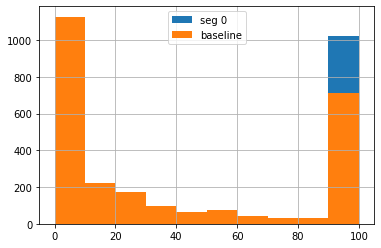

In [412]:
rmt_df.f1_seg_0.hist()
baseline_df.f1_seg_2.hist()
# rmt_df.f1_seg_1.hist()
plt.legend(['seg 0', 'baseline',])

In [ ]:
(rmt_df.f1_seg_0 == 0).mean()

In [ ]:
(rmt_df.f1_seg_1 - rmt_df.f1_seg_0).mean()

In [ ]:
# rmt_df[rmt_df.f1_seg_1 >  0].target_text.value_counts()

In [ ]:
# rmt_df[rmt_df.f1_seg_0 >  0].target_text.value_counts()

#### Valid

In [413]:
# rmt_df = pd.read_csv('tables/qasper-valid-rm-t5-1002-10.csv').sort_values(['ids']).reset_index()
rmt_df = pd.read_csv('tables/qasper-valid-rm-t5-499-10.csv').sort_values(['ids']).reset_index()
rmt_df['input'] = rmt_df.ids.apply(lambda x: id2text_valid[x])

baseline_df = pd.read_csv('tables/qasper-valid-t5-base.csv').sort_values(['ids']).reset_index()
baseline_df['input'] = baseline_df.ids.apply(lambda x: id2text_valid[x])
baseline_df['f1_seg_1'] = baseline_df['f1_seg_2']

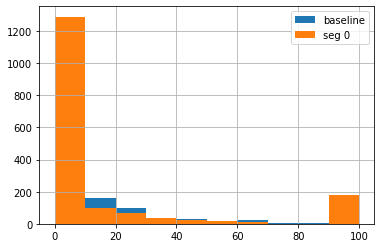

In [414]:
baseline_df.f1_seg_2.hist()
rmt_df.f1_seg_0.hist()
# rmt_df.f1_seg_1.hist()
plt.legend(['baseline', 'seg 0', 'seg 1'])

In [418]:
(rmt_df.f1_seg_0).mean(), (baseline_df.f1_seg_1).mean()

(14.848953476245654, 15.213263557358053)

In [419]:
# rmt_df[(rmt_df.f1_seg_1 - rmt_df.f1_seg_0) < 0]

In [424]:
rmt_df[(baseline_df.f1_seg_1 - rmt_df.f1_seg_0) > 0].preds_seg_0.value_counts()

Unanswerable                                               54
Yes                                                        18
No                                                         10
accuracy                                                   10
BIBREF14                                                    4
                                                           ..
BiDAF, R-NET, and QANet                                     1
Bi-directional, multi-lingual                               1
pooling function                                            1
CoNLL 2014                                                  1
a LSTM with a corresponding knowledge base, a LSTM with     1
Name: preds_seg_0, Length: 202, dtype: int64

In [425]:
rmt_df[(baseline_df.f1_seg_1 - rmt_df.f1_seg_0) < 0].preds_seg_0.value_counts()

Yes                                                                       27
Unanswerable                                                              20
No                                                                        14
English                                                                    7
LSTM                                                                       7
                                                                          ..
vulgarity, gender, proximity to target, proximity to target                1
corpus of news articles labelled as propaganda, trusted, hoax, or sati     1
in a conversational fashion by imitating human apprehensions and in        1
by calculating variance from the outputs                                   1
a LSTM with a corresponding knowledge base, a LSTM with                    1
Name: preds_seg_0, Length: 180, dtype: int64

In [426]:
n_segments = 2
def split(text, n_segments=n_segments):
    premise = text.split('?')[0]
    encoded = tokenizer.encode(text, **encode_plus_kwargs, add_special_tokens=False)
    segments = np.split(np.array(encoded), n_segments)    
    texts = [tokenizer.decode(s) for s in segments]
    
    
    return [premise] + texts

In [427]:
max_i = 1

### analysis table

In [428]:
f1_cols = { 'rmt-t5-seg-1': rmt_df.f1_seg_0, 't5': baseline_df.f1_seg_1}
comp_df = pd.DataFrame(index = f1_cols.keys(), columns = f1_cols.keys())

for better_name, better_f1 in f1_cols.items():
    for worse_name, worse_f1 in f1_cols.items():
        num_occ = (better_f1 > worse_f1).sum()
        comp_df.loc[worse_name, better_name] = num_occ
        
comp_df = (comp_df / rmt_df.shape[0]).astype(float).round(2)
comp_df

,rmt-t5-seg-1,t5
rmt-t5-seg-1,0.00,0.21
t5,0.17,0.00


### look at texts

In [437]:
# rmt_df[baseline_df.f1_seg_1 > rmt_df.f1_seg_0].preds_seg_0.value_counts() / sum(baseline_df.f1_seg_1 > rmt_df.f1_seg_0)
baseline_df[baseline_df.f1_seg_1 > rmt_df.f1_seg_0].preds.value_counts() / sum(baseline_df.f1_seg_1 > rmt_df.f1_seg_0)

Unanswerable                                                                                                    0.076087
Yes                                                                                                             0.040761
No                                                                                                              0.024457
English                                                                                                         0.010870
accuracy                                                                                                        0.010870
                                                                                                                  ...   
the well-studied phenomenon by which the perception of what we hear can be influenced by                        0.002717
they draw from their use of emotion detection methods to detect similarities in the emotional appeal of ISIS    0.002717
they combine a deep learning mod

In [439]:
# max_i = 10
mask = (rmt_df.f1_seg_0 - baseline_df.f1_seg_1) > 0
print(f'Segment 0 better than baseline: {sum(mask)}\n\n')
slice = rmt_df[mask].reset_index()
slice_bl = baseline_df[mask].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    # bl_pred = baseline_df[baseline_df.ids == row['ids']].preds.iloc[0]
    bl_pred = slice_bl.iloc[i].preds
    # print(slice.iloc[i])
    # print(slice_bl.iloc[i])
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nbaseline: {bl_pred}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break

Segment 0 better than baseline: 302


What datasets are used to assess the performance of the system

What datasets are used to assess the performance of the system? Introduction Topic identification (topic ID) on speech aims to identify the topic(s) for given speech recordings, referred to as spoken documents, where the topics are a predefined set of classes or labels. This task is typically formulated as a three-step process. First, speech is tokenized into words or phones by automatic speech recognition (ASR) systems BIBREF0, or by limited-vocabulary keyword spotting BIBREF1. Second, standard text-based processing techniques are applied to the resulting tokenizations, and produce a vector representation for each spoken document, typically a bag-of-words multinomial representation, or a more compact vector given by probabilistic topic models BIBREF2, BIBREF3. Finally, topic ID is performed on the spoken document representations by supervised training of classifiers, such as Bayesian 

In [ ]:
max_i = 5
mask = (rmt_df.f1_seg_0 - baseline_df.f1_seg_1) < 0
print(f'Segment 0 worse than baseline: {sum(mask)}\n\n')
slice = rmt_df[mask].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    bl_pred = baseline_df[baseline_df.ids == row['ids']].preds.iloc[0]
    # bl_pred = baseline_df[baseline_df.ids == row['ids']].preds
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nseg_1: {row['preds_seg_1']}\nbaseline: {bl_pred}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break

In [ ]:
max_i = 20
mask = (rmt_df.f1_seg_1 - baseline_df.f1_seg_1) > 0
print(f'Segment 1 better than baseline: {sum(mask)}\n\n')
slice = rmt_df[mask].reset_index()
for i, row in slice.iterrows():
    inp = row['input']
    spl = '\n\n'.join(split(row['input']))
    bl_pred = baseline_df[baseline_df.ids == row['ids']].preds.iloc[0]
    print(f"{spl}\nseg_0: {row['preds_seg_0']},\nseg_1: {row['preds_seg_1']}\nbaseline: {bl_pred}\ntarget: {row['target_text']}\n\n")
          
    if i > max_i:
        break